# Tutorial on how to simulate genetic associations based on HapMap data

This tutorial demonstrates how genotype data can be used to generate simulated phenotype datasets and how we can run an eQTL scan, including looking at step-wise association analysis.

In [22]:
# activate inline plotting
%matplotlib inline
from setup import *

#### 1000 Genomes

In [23]:
#load 1000 genomes data
#the data used in this study have been pre-converted into an hdf5 file. 
#to preprocess your own data, please use limix command line brinary
genotype_file = tutorial_data.get_file('1000g')
annotation_file = tutorial_data.get_file('1000g_annotation')
geno_reader_1000G = gr.genotype_reader_tables(genotype_file)
#read annotation
fa = h5py.File(annotation_file,'r')
population_1000G = fa['Population'][:]
pos_1000G = geno_reader_1000G.getPos()

In [24]:
#select populations
#Ipop = (population_1000G=='CEU') | (population_1000G=='YRI') | (population_1000G=='GBR') | (population_1000G=='FIN')
#population_1000G = population_1000G[Ipop]
M1000G = geno_reader_1000G.getGenotypes()#[Ipop]

#### Arabidopsis

In [25]:
# atwell 107
file_name = tutorial_data.get_file('arab107')
geno_reader_atwell  = gr.genotype_reader_tables(file_name)
Matwell = geno_reader_atwell.getGenotypes()
posatwell = geno_reader_atwell.getPos()
Matwell = Matwell[:,::10]
Matwell = Matwell[0:200,:]
posatwell = posatwell[::10]

#### Yeast Cross

In [26]:
# ByXRM
file_name = tutorial_data.get_file('BYxRM')
geno_reader_BYxRM  = gr.genotype_reader_tables(file_name)
# M is a binary matrix [samples,genotypes]
MBYxRM = geno_reader_BYxRM.getGenotypes()
posBYxRM = geno_reader_BYxRM.getPos()

#### Select Dataset

In [27]:
dataset = '1000G'#'Atwell','BYxRM'

if dataset=='1000G':
    M = M1000G
    POS = pos_1000G
    minor_allele=2
elif dataset=='Atwell':
    M = Matwell
    POS = posatwell
    minor_allele=1
elif dataset=='BYxRM':
    M= MBYxRM
    POS = posBYxRM
    minor_allele=1

#### Filter by minor allele frequency

In [28]:
M = M[:1000, :]

In [29]:

#M1000G = geno_reader_1000G.getGenotypes()

#note: the 1000g samples have different populational background.
#a subset of the samples are YRI and the remaining CEU
#you can query this information using the array "popuatlion_1000G"

#filter by allele frequency
af = calc_AF(M,minor=minor_allele)
Iok = (af['af']>=0.05) & ((af['af']<0.95))
M = M[:,Iok]
POS = POS[Iok]

N,S = M.shape

#### Simulate Phenotypes

We will simulate phenotypes that consist of a strong genetic effects from a few SNPs, genetic effects driven by sample relatedness and independent noise/environment effects.

First, compute the relatedness matrix from the true genotypes.

In [30]:
snps = sp.array(M,dtype='float')
snps_std = snps - snps.mean(axis=0)
snps_std /= snps_std.std(axis=0)
K = sp.dot(snps_std,snps_std.T)
K /= K.diagonal().mean()

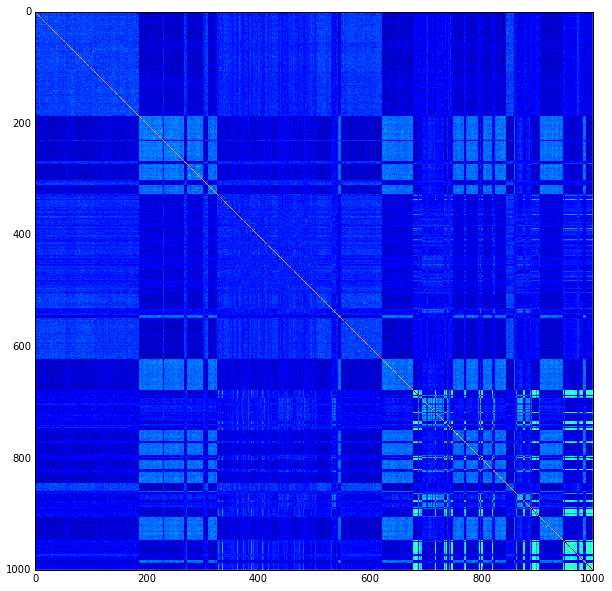

In [32]:
pl.figure(figsize=(10,10))
pl.imshow(K,aspect='auto',interpolation='none')

In [33]:
#set random seed to make this reproducible
sp.random.seed(5)

#specify number of causal variants and total variance attributable to genetic effects
Vfg = 0.3 # foreground loci variance
Vpop = 0.6 # pop. structure variance
Vresidual = 1.0-Vpop-Vfg #noise variance
#number of causal loci and polygenic signal of population structure
Nfg = 5

#foreground (causal) SNPs (strong)
idx_snps_fg = sp.random.permutation(S)[0:Nfg] # select Nfg SNPs randomly
W_fg = 2.*(sp.randn(Nfg)<0)-1 # simulate forground SNP effect sizes
snps_fg = snps[:,idx_snps_fg]
snps_fg -= snps_fg.mean(axis=0)
snps_fg /= snps_fg.std(axis=0)
y_fg      = sp.dot(snps_fg,W_fg)

# simulate population effect (from relatedness matrix)
y_pop = np.random.multivariate_normal(np.zeros(N), cov=K)

#simulate random noise
y_residual = sp.randn(N)

#normalize and add up
y =   y_fg/y_fg.std()*sp.sqrt(Vfg) 
y +=  y_pop/y_pop.std()*sp.sqrt(Vpop)
y +=  y_residual/y_residual.std()*sp.sqrt(Vresidual)
y = y[:,sp.newaxis]


#### Run LM and LMM

In [34]:
#run gwas:
covs = None
test = 'lrt'
lm = qtl.test_lm(snps=snps,pheno=y,
                   covs=covs, test=test)

lmm = qtl.test_lmm(snps=snps,pheno=y,K=K,
                   covs=covs, test=test)
pos = POS['pos'].values
pv_lmm  = lmm.getPv().ravel()
pv      = lm.getPv().ravel()

## QTL scan on the simulated dataset

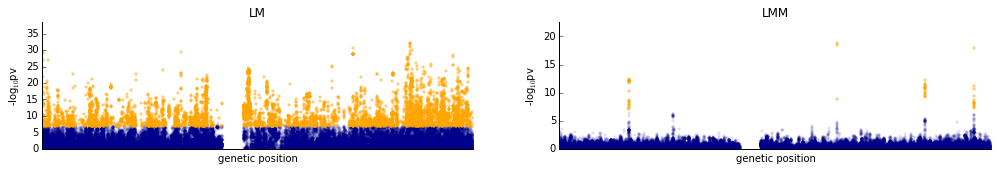

In [35]:
pl.figure(figsize=[17,5])
plt.subplot(2,2,1)
# Genome-wide manhatton plots for one phenotype:
pos = POS['pos'].values
plot_manhattan(pos,pv)
pl.title('LM')
plt.subplot(2,2,2)
pos = POS['pos'].values
plot_manhattan(pos,pv_lmm)
pl.title('LMM')



What are the loci that are being discovered. Are all associations found by LM background signals or SNPs with a large effect?

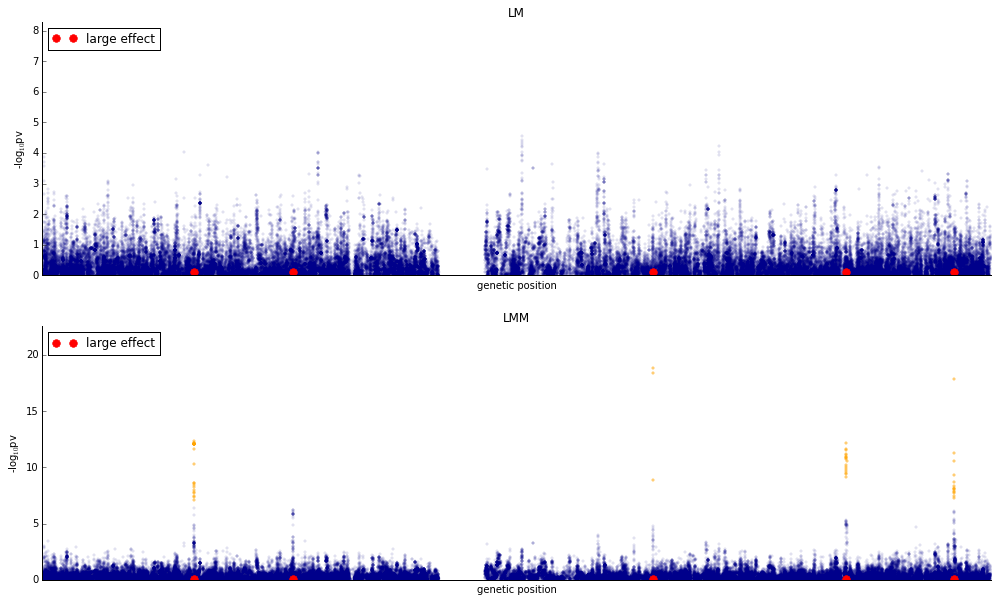

In [40]:
pl.figure(figsize=[17,10])
plt.subplot(2,1,1)
# Genome-wide manhatton plots for one phenotype:
pos = POS['pos'].values
plot_manhattan(pos,pv)
#plot causal loci and background loci
pl.plot(pos[idx_snps_fg],0.1*sp.ones(len(idx_snps_fg)),'r.',markersize=15,label='large effect')
pl.legend(loc='upper left')
pl.title('LM')
plt.subplot(2,1,2)
plot_manhattan(pos,pv_lmm)
#plot causal loci and background loci
pl.plot(pos[idx_snps_fg],0.1*sp.ones(len(idx_snps_fg)),'r.',markersize=15,label='large effect')
pl.legend(loc='upper left')
pl.title('LMM')

## Observations
* Population structure results in associations at non-causal loci (neither background nor foreground).
* The LMM effectively corrects for structure such that causal loci stand out to a greater extent.
* The power to detect causal loci (sensitivity) of the LMM decreases. 

# Stepwise association analysis
* Stepwise inclusion of lead SNPs into the model


In [37]:
alpha = 0.05/snps.shape[1]
lmm,RV = qtl.forward_lmm(snps=snps,pheno=y,K=K,
                   covs=covs, test=test,threshold=alpha,maxiter=10)


In [38]:
RV.keys()

['iadded', 'pvall', 'pvadded']

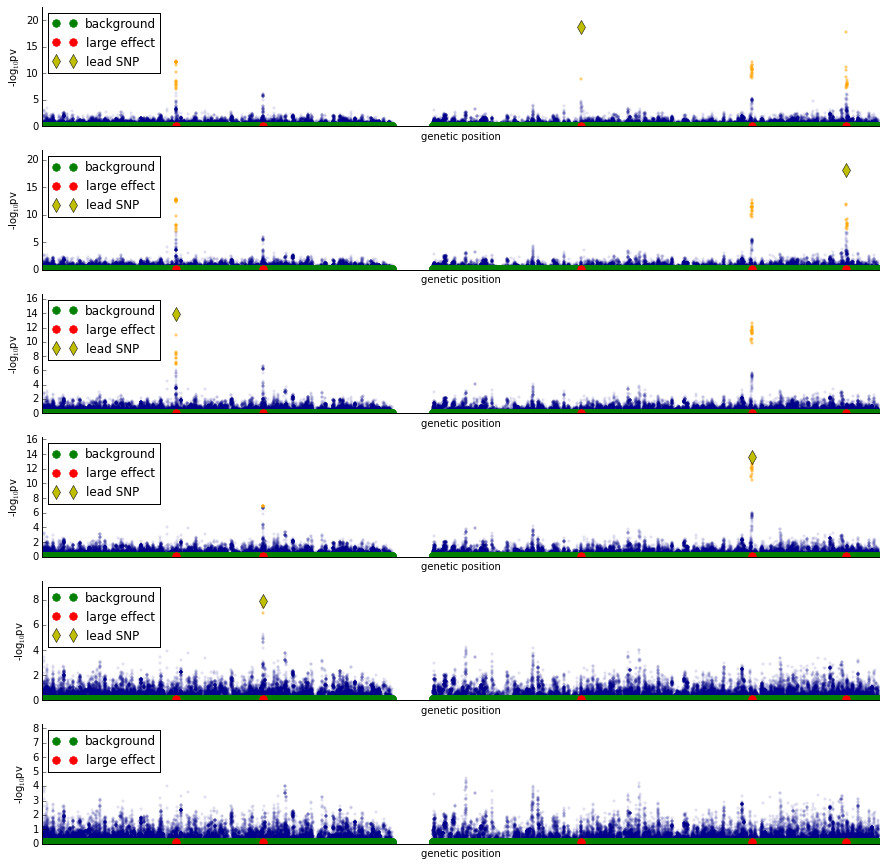

In [39]:
pl.figure(figsize=[15,15])
Nadded = RV['pvall'].shape[0]

for i in xrange(Nadded):
    plt.subplot(Nadded,1,1+i)
    pv = RV['pvall'][i]
    plot_manhattan(pos,pv)
    pl.plot(pos[idx_snps_bg],0.1*sp.ones(len(idx_snps_bg)),'g.',markersize=15,label='background')
    pl.plot(pos[idx_snps_fg],0.1*sp.ones(len(idx_snps_fg)),'r.',markersize=15,label='large effect')
    
    #mark the most associated SNP
    if i<(Nadded-1):
        pl.plot(pos[RV['iadded'][i]],-sp.log10(pv)[RV['iadded'][i]],'dy',markersize=10,label='lead SNP')    
    pl.legend(loc='upper left')



## Observations
* Nearby associaations can be dissected into individual causal signals (allelic heterogeneity).
* Secondary associations can get stronger by conditioning on nearby SNPs.